### Hyperparameter Tuning using GridSearchCV

switching to python3.9

In [2]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.model_selection import GridSearchCV

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Create Snowpark Session
with open('creds.json') as f:
    connection_parameters = json.load(f)

session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "CC_DB"."PUBLIC"
Current Warehouse: "CC_WH"


### Model Building

Parameter-Tuning using a Snowpark-Optimized Warehouse for better performance.

In [4]:
session.use_warehouse('HOL_WH_HIGH_MEM')

In [5]:
train_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN')
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')

In [6]:
feature_cols = train_sdf.columns
feature_cols.remove('TARGET')
feature_cols.remove('ID')
target_col = 'TARGET'

grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid={
        'n_estimators':[10,50,100],
        'max_depth':[2,3,4]
        },
    n_jobs = -1,
    input_cols = feature_cols,
    label_cols = target_col,
    output_cols = 'PREDICTION',
    scoring="f1",
    )

In [7]:
#!pip uninstall -y lightgbm
# Fit the model using GridSearchCV
grid_search.fit(train_sdf)

The version of package 'snowflake-snowpark-python' in the local environment is 1.30.0, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.
Package 'snowflake-telemetry-python' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.
The version of package 'xgboost' in the local environment is 2.1.4, which does not fit the criteria for the requirement 'xgboost==2.1.1'. Your UDF might not work when the package version is different between the server and your local environment.
/Users/navisha/Desktop/PROJECTS/machine-learning-with-snowpark/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:20:24] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) o

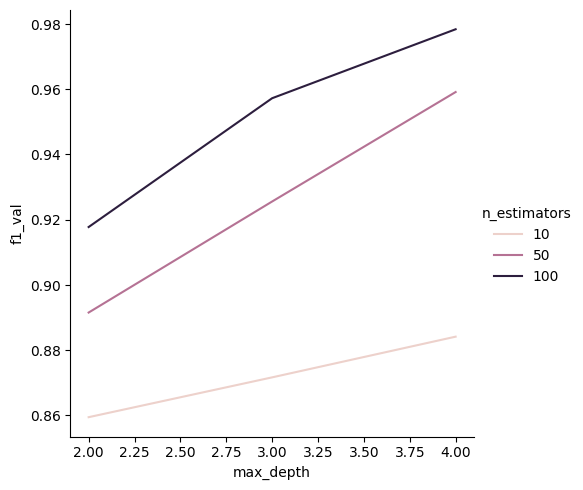

In [8]:
# Analyze grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
max_depth_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    max_depth_val.append(param_dict["max_depth"])

f1_val = gs_results["mean_test_score"]
gs_results_df = pd.DataFrame(data={"n_estimators":n_estimators_val,
                                   "max_depth":max_depth_val, 
                                   'f1_val':f1_val})
sns.relplot(data=gs_results_df, x="max_depth", y="f1_val", hue="n_estimators", kind='line')
plt.show()

In [ ]:
best_model = SomeModelClass(max_depth=4, n_estimators=100)
best_model.fit(X_train, y_train)